In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import imutils.paths as path
from tqdm import tqdm
import os
from skimage.io import imread
import cv2
from tqdm import tqdm
import imutils

In [2]:
import tensorflow as tf
from keras.models import Model, Sequential
from keras.layers import Input, Activation, Dense, Conv2D, MaxPooling2D,BatchNormalization, ZeroPadding2D, Flatten
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical

Using TensorFlow backend.


In [64]:
positifList=os.listdir('brain_tumor_dataset/yes/')
negatifList=os.listdir('brain_tumor_dataset/no/')
nameFile = positifList+negatifList
clsName = os.listdir('brain_tumor_dataset/')

In [4]:
def crop_brain_contour(image, plot=False):
    #convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray,(5,5), 0)
    
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations = 2)
    thresh = cv2.dilate(thresh, None, iterations = 2)
    
    contour = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contour = imutils.grab_contours(contour)
    c = max(contour, key=cv2.contourArea)
    
    extLeft = tuple(c[c[:,:,0].argmin()][0])
    extRight = tuple(c[c[:,:,0].argmax()][0])
    extTop = tuple(c[c[:,:,1].argmin()][0])
    extBot = tuple(c[c[:,:,1].argmax()][0])
    
    new_image = new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]
    if plot:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.title('Original Image')
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)
        plt.title('Cropped Image')
        plt.show()
    return new_image

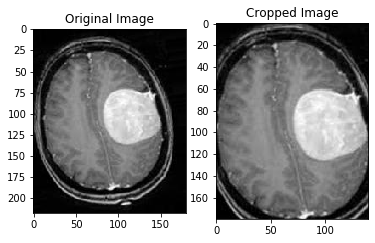

In [5]:
ex_img = cv2.imread('brain_tumor_dataset/yes/aug_Y1_0_1595.jpg')
ex_crop_img = crop_brain_contour(ex_img, True)

In [31]:
def loadCitra (listData, labeling):
    data = []
    label = []
    for i in tqdm (listData):
        if (labeling == 0):
            sample = cv2.imread ('brain_tumor_dataset/yes/'+i)
        elif (labeling == 1):
            sample = cv2.imread ('brain_tumor_dataset/no/'+i)
        sample = crop_brain_contour(sample, plot=False)
        sampleResize = cv2.resize(sample, dsize=(64, 64))
        sampleResize = sampleResize /255. 
        data.append(sampleResize)
        label.append(labeling)
    return (data, label)

mengambil data dari path data untuk yang postif tumor otak yang nama folder dan direktorinya (brain_tumor_dataset/yes/), dan juga mengambil data untuk yang negatif tumor otak dengan nama folder dan direktorinya (brain_tumor_dataset/no/), data yag sudah di masukkan kemudian data akan di hilangkan noise yang tidak perlu dengan fungsi "crop_brain_contour" kemudian data tersebut di rize dan di normalisasi yang data tersebut kemudian di append ke dalam 1 list data

In [34]:
citraPositif, IDpositif=loadCitra(positifList, 0)
citraArrayP = np.array (citraPositif)
print (citraArrayP.shape)
print("panjang IDpositif:" + str(len(IDpositif))+"\n")

citraNegatif, IDnegatif=loadCitra(negatifList, 1)
citraArrayN = np.array (citraNegatif)
print (citraArrayN.shape)
print("panjang IDnegatif: " + str(len(IDnegatif))+"\n")

citra = citraPositif+citraNegatif
ID=IDpositif+IDnegatif
citra = np.array(citra)
IDs=np.array(ID)
print (IDs)
print("Jumlah Citra: " + str(len(citra)))
print("panjang ID: " + str(len(IDs)))

100%|██████████| 1085/1085 [00:05<00:00, 190.46it/s]


(1085, 64, 64, 3)
panjang IDpositif:1085



100%|██████████| 980/980 [00:04<00:00, 230.80it/s]


(980, 64, 64, 3)
panjang IDnegatif: 980

Jumlah Citra: 2065
panjang ID: 2065


mengambil data yang di load pada fungsi "loadCitra" dan juga menampilkan ukuran data dan ukuran shape dari data, setelah itu data di tampilan dengan kelasnya pada code dibawah ini yang masihng setiap kelas di tampilkan 5 data

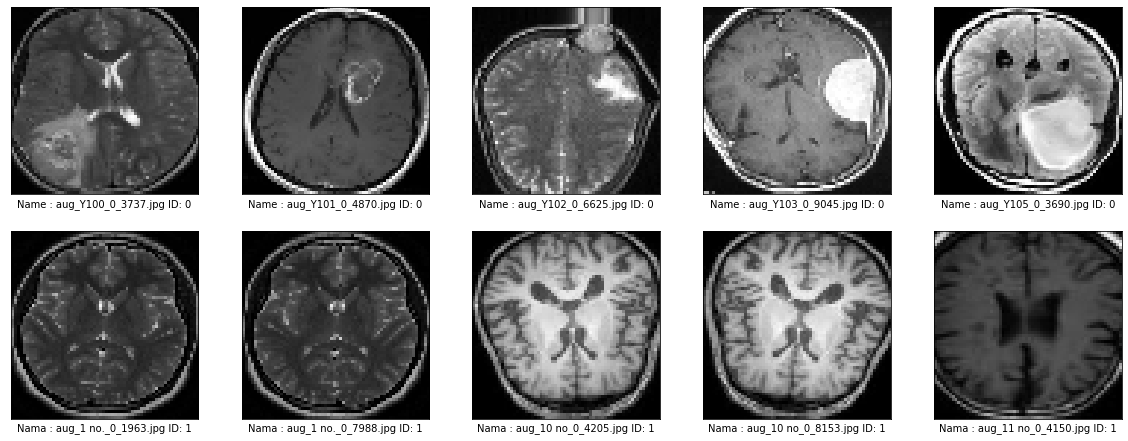

In [66]:
plt.figure(figsize=(20,20))
idx=0;
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(True)
    if (i<5):
        plt.imshow(citra[idx], cmap=plt.cm.Greys_r)
        plt.xlabel("Name : {}".format(nameFile[idx])+ " ID: {}".format(IDs[idx]))
        idx+=9
        if i==4:
            idx=len(positifList);
    else:
        plt.imshow(citra[idx], cmap=plt.cm.Greys_r)
        plt.xlabel("Nama : {}".format(nameFile[idx])+ " ID: {}".format(IDs[idx]))
        idx+=6
plt.show()

data yang sudah di load kemudian di tampilkan dengan Id-nya

In [38]:
x_train, x_test, l_train, l_test =  train_test_split(citra, IDs, stratify=IDs, test_size=0.3)
y_train=to_categorical(l_train) 
y_test= to_categorical(l_test)

pada code diatas kemudian berfungsi untuk membagi untuk data menjadi data train dan data test

In [42]:
model = tf.keras.Sequential()

# Must define the input shape in the first layer of the neural network
model.add(tf.keras.layers.Conv2D(filters=16,kernel_size=9, padding='same', activation='relu', input_shape=(64, 64,3))) 
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model.add(tf.keras.layers.Dropout(0.45))

model.add(tf.keras.layers.Conv2D(filters=16,kernel_size=9,padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.Conv2D(filters=36, kernel_size=9, padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.15))


model.add(tf.keras.layers.Dense(2, activation='sigmoid'))

# Take a look at the model summary
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 64, 64, 16)        3904      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 32, 32, 16)        0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 32, 32, 16)        20752     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 16, 16, 16)        0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 16, 16, 36)      

In [43]:
model.compile(loss='binary_crossentropy',
             optimizer=tf.keras.optimizers.Adam(),
             metrics=['acc'])

In [44]:
history=model.fit(x_train,
         y_train,
         batch_size=32,
         epochs=150,
         verbose=2,
         validation_data=(x_test, y_test))

Epoch 1/150
46/46 - 14s - loss: 0.6984 - acc: 0.5211 - val_loss: 0.6930 - val_acc: 0.5210
Epoch 2/150
46/46 - 14s - loss: 0.6930 - acc: 0.5017 - val_loss: 0.6911 - val_acc: 0.5532
Epoch 3/150
46/46 - 14s - loss: 0.6720 - acc: 0.5661 - val_loss: 0.6649 - val_acc: 0.6177
Epoch 4/150
46/46 - 14s - loss: 0.6304 - acc: 0.6408 - val_loss: 0.5939 - val_acc: 0.7065
Epoch 5/150
46/46 - 14s - loss: 0.5712 - acc: 0.6962 - val_loss: 0.5302 - val_acc: 0.7387
Epoch 6/150
46/46 - 14s - loss: 0.5163 - acc: 0.7474 - val_loss: 0.4478 - val_acc: 0.8113
Epoch 7/150
46/46 - 14s - loss: 0.4553 - acc: 0.7986 - val_loss: 0.4270 - val_acc: 0.8242
Epoch 8/150
46/46 - 14s - loss: 0.3946 - acc: 0.8284 - val_loss: 0.4044 - val_acc: 0.8097
Epoch 9/150
46/46 - 14s - loss: 0.3822 - acc: 0.8401 - val_loss: 0.3909 - val_acc: 0.8145
Epoch 10/150
46/46 - 14s - loss: 0.3476 - acc: 0.8450 - val_loss: 0.3852 - val_acc: 0.8339
Epoch 11/150
46/46 - 14s - loss: 0.3154 - acc: 0.8740 - val_loss: 0.3183 - val_acc: 0.8984
Epoch 12

KeyboardInterrupt: 

In [ ]:
# Evaluate the model on test set
# score = model.evaluate(x_test, y_test, verbose=0)

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

test_loss, test_acc = model.evaluate(x_train, y_train)

print('Trainning accuracy:', test_acc)

test_loss, test_acc = model.evaluate(x_test, y_test)

print('Test accuracy:', test_acc)
# Print test accuracy

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
def generateClassificationReport(y_test,y_pred):
    print(classification_report(y_test,y_pred))
    print(confusion_matrix(y_test,y_pred))    
    print('accuracy is ',accuracy_score(y_test,y_pred))
    
y_pred=[];
predictions = model.predict(x_test)
for i in range (len(predictions)):
    predicted_label = np.argmax(predictions[i])
    y_pred.append(predicted_label)
generateClassificationReport(l_test,y_pred)

In [ ]:
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img,  cmap=plt.cm.Greys_r)
    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'
    plt.xlabel("{} {:2.0f}% ({})".format(clsName[:][predicted_label],
                                100*np.max(predictions_array),
                                clsName[:][true_label]),
                                color=color)



img = np.copy(x_test)
#Vew Results
num_rows = 120/6
num_cols = 6
num_images = len(x_test)
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(100):
    plt.subplot(num_rows, num_cols,i+1)
    plot_image(i, predictions, l_test, img)
  #plt.subplot(num_rows, 2*num_cols, 2*i+2)
  #plot_value_array(i, predictions, l_test)
plt.show()